In [1]:
import numpy as np
import time
import copy
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,SubsetRandomSampler
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,precision_score, recall_score

In [2]:
data_dir = 'E:/train_data'

In [3]:
transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transforms[x])
                  for x in ['train', 'val', 'test']}

In [5]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 13619
     Root location: E:/train_data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 2719
     Root location: E:/train_data\val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 1825
     Root location: E:/train_data\test
     StandardTransform
 Transform: Compose(
            

In [6]:
class_names=image_datasets['train'].classes


In [7]:
class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [8]:

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=2)
               for x in ['train', 'val', 'test']}

In [9]:

data_size = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
model_googlenet = models.googlenet(pretrained=True)

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
model_googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [12]:
num_features = model_googlenet.fc.in_features
model_googlenet.fc = torch.nn.Linear(num_features, len(class_names))

In [13]:
model_googlenet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / data_size[phase]
            epoch_acc = running_corrects.double() / data_size[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model


In [15]:
model_googlenet=model_googlenet.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()

In [18]:
optimizer_conv = optim.Adam(model_googlenet.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model_x = train_model(model_googlenet, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9949 Acc: 0.6717
val Loss: 0.3402 Acc: 0.8797

Epoch 1/24
----------
train Loss: 0.6147 Acc: 0.7957
val Loss: 0.3013 Acc: 0.8930

Epoch 2/24
----------
train Loss: 0.4940 Acc: 0.8410
val Loss: 0.2166 Acc: 0.9287

Epoch 3/24
----------
train Loss: 0.4316 Acc: 0.8606
val Loss: 0.3468 Acc: 0.8926

Epoch 4/24
----------
train Loss: 0.3925 Acc: 0.8724
val Loss: 0.2162 Acc: 0.9242

Epoch 5/24
----------
train Loss: 0.3578 Acc: 0.8817
val Loss: 0.1875 Acc: 0.9356

Epoch 6/24
----------
train Loss: 0.3254 Acc: 0.8910
val Loss: 0.1645 Acc: 0.9437

Epoch 7/24
----------
train Loss: 0.2090 Acc: 0.9311
val Loss: 0.0497 Acc: 0.9812

Epoch 8/24
----------
train Loss: 0.1663 Acc: 0.9441
val Loss: 0.0495 Acc: 0.9834

Epoch 9/24
----------
train Loss: 0.1538 Acc: 0.9478
val Loss: 0.0489 Acc: 0.9820

Epoch 10/24
----------
train Loss: 0.1457 Acc: 0.9510
val Loss: 0.0342 Acc: 0.9882

Epoch 11/24
----------
train Loss: 0.1373 Acc: 0.9534
val Loss: 0.0306 Acc: 0.9886

Ep

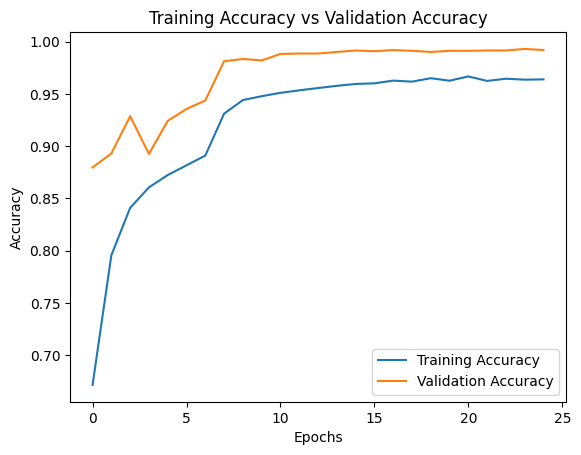

In [1]:
import matplotlib.pyplot as plt


epochs = [i for i in range(25)]
train_acc = [0.6717, 0.7957, 0.8410, 0.8606, 0.8724, 0.8817, 0.8910, 0.9311, 0.9441, 0.9478, 0.9510, 0.9534, 0.9556, 0.9577, 0.9595, 0.9601, 0.9627, 0.9617, 0.9650, 0.9626, 0.9667, 0.9624, 0.9645, 0.9636, 0.9639]
val_acc = [0.8797, 0.8930, 0.9287, 0.8926, 0.9242, 0.9356, 0.9437, 0.9812, 0.9834, 0.9820, 0.9882, 0.9886, 0.9886, 0.9901, 0.9915, 0.9908, 0.9919, 0.9912, 0.9901, 0.9912, 0.9912, 0.9915, 0.9915, 0.9930, 0.9919]



plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')
plt.legend()


plt.show()

In [19]:
torch.save(model_googlenet,'googlenet-model1.pth')

In [2]:
model_googlenet = torch.load('googlenet-model1.pth')

In [15]:
model_googlenet.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [19]:
with torch.no_grad():
    
    accuracy = 0
    total_samples = 0
    correct_predictions = 0
    predicted_labels = []
    true_labels = []

   
    for images, labels in dataloaders['test']:
        images = images.to(device)
        labels = labels.to(device)

        
        outputs = model_googlenet(images)

       
        _, predicted = torch.max(outputs.data, 1)

        
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

       
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

   
    accuracy = correct_predictions / total_samples

    precision = precision_score(true_labels, predicted_labels, average='weighted')
    
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    
    f_score = f1_score(true_labels, predicted_labels, average='weighted')

   
    confusion_mat = confusion_matrix(true_labels, predicted_labels)

print("Accuracy: {:.5f}%".format(accuracy))



Accuracy: 0.99288%


In [20]:
print("precision: {:.5f}".format(precision))

precision: 0.99290


In [21]:
print("recall: {:.5f}".format(recall))

recall: 0.99288


In [22]:
print("F-score: {:.5f}".format(f_score))

F-score: 0.99285


In [23]:
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[100   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  16   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 213   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  96   0   0   1   0   3   0   0   0]
 [  0   0   0   0   1 191   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  96   0   0   0   0   0   0]
 [  1   0   0   0   0   1   0 176   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 168   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1 136   0   0   4]
 [  0   0   0   1   0   0   0   0   0   0 321   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  39   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 160]]


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

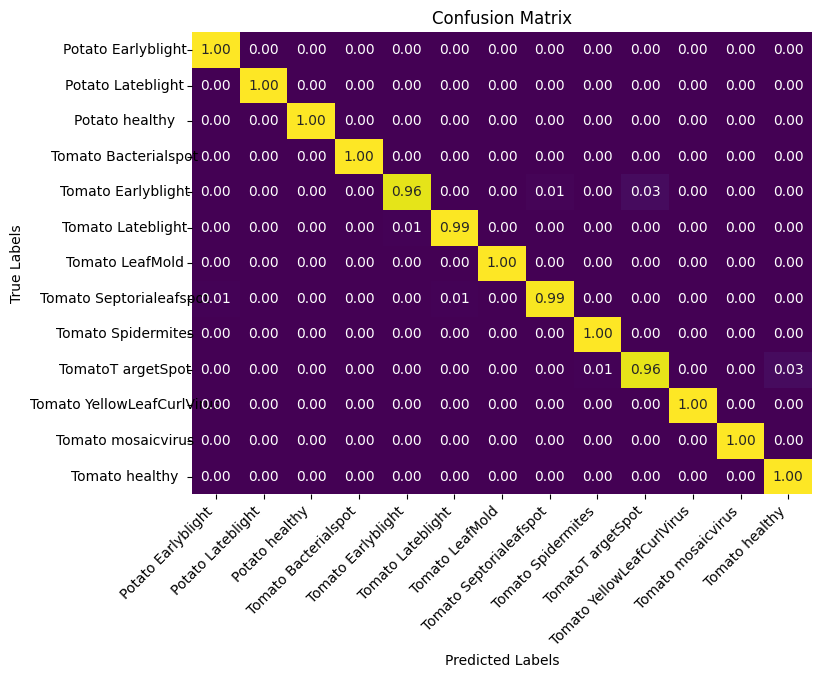

In [25]:

class_labels =  ['Potato Earlyblight','Potato Lateblight','Potato healthy','Tomato Bacterialspot','Tomato Earlyblight',
                 'Tomato Lateblight','Tomato LeafMold','Tomato Septorialeafspot','Tomato Spidermites','TomatoT argetSpot',
                 'Tomato YellowLeafCurlVirus','Tomato mosaicvirus','Tomato healthy']


normalized_confusion_mat = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]


fig, ax = plt.subplots(figsize=(8, 6))


heatmap = sns.heatmap(normalized_confusion_mat, annot=True, fmt='.2f', cmap='viridis', cbar=False, ax=ax)


ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')

heatmap.set_xticklabels(class_labels, rotation=45, ha='right')
heatmap.set_yticklabels(class_labels, rotation=0, ha='center')


ax.tick_params(axis='y', pad=45)


plt.xticks(rotation=45)




plt.show()







In [ ]:
"""
['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']


"""

In [3]:
from torchsummary import summary

In [4]:
summary(model_googlenet, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,